In [15]:
import numpy as np
import scipy.signal as ss
import matplotlib
import matplotlib.pyplot as plt


from mpdaf.obj import Cube

from shade import proba_tools,shade_main,parameters
reload(proba_tools)
reload(shade_main)
reload(parameters)
%matplotlib inline
plt.rcParams['image.origin']='lower'
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['figure.figsize']=(10,10)

In [3]:
listID=[43,]#43, 92, 95, 139]

cube=Cube('/home/data/MUSE/0.31/DATACUBE-HDFS-v031c.fits')

In [16]:
### choix des paramètres, 
# sim=False : il ne s'agit pas d'une source simu, on permet
# lmbdaShift : variation max dans la famille de spectres de tests créés (on va de -lmbdaShift à + lmbdaShift)
# LW : demi-largeur de la zone étudié en lmbda
# SW : demi-largeur de la zone étudié en spatial
params=parameters.Params(sim=False,lmbdaShift=7,LW=15,SW=25)

### creation de l'objet méthode à partir de la liste d'ID, cela permet de construire des sources plus grandes que celles obtenues dans le catalogue
# on peut sinon injecter une liste de sources avec listSources=
shade1=shade_main.SHADE(listID=listID,params=params,catalog='/home/data/MUSE/HDFS/MasterCatalogue-1.34.fits',cube=cube) 

#preprocessing avec parametrisation : ici,on fait la soustraction du continu par filtre median, et on force le preprocessing
paramsPreProcess=parameters.ParamsPreProcess(methodRC='medfilt',forceProcess=True)
shade1.preprocess(paramsPreProcess=paramsPreProcess)


### Detection
paramsDetection=parameters.ParamsDetection()
shade1.detect()

### PostProcess
# FDR: control with FDR (instead of PFA)
# qvalue: compute qvalues
# newSource: store results in a new source object (if not results are added to the input sources)
paramsPostProcess=parameters.ParamsPostProcess(threshold=0.01,
                 FDR=True,
                 qvalue=True,
                 newSource=True,)

shade1.postprocess(paramsPostProcess=paramsPostProcess)

/home/raphael/miniconda/envs/env27/lib/python2.7/site-packages/numpy/ma/core.py:3158: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 331 but corresponding boolean dimension is 51
  dout = self.data[indx]
/home/raphael/miniconda/envs/env27/lib/python2.7/site-packages/numpy/ma/core.py:3213: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 331 but corresponding boolean dimension is 51
  dout._mask = _mask[indx]


Les résultats sont stockés dans listResultSources (liste de sources)

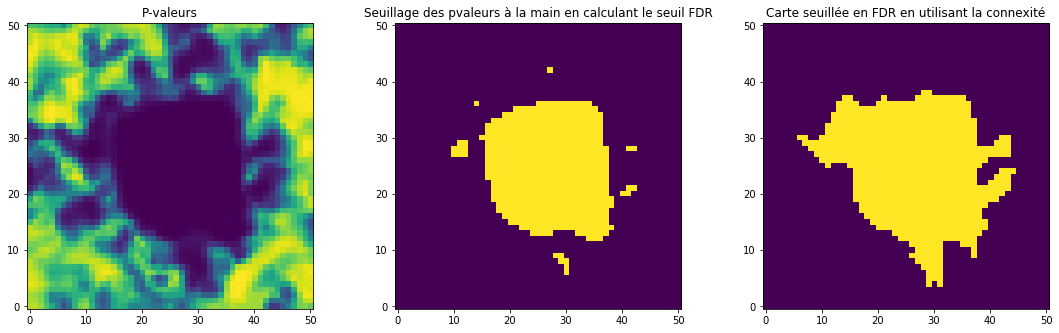

In [22]:
plt.rcParams["figure.figsize"]=(15,15)
plt.subplot(131)
plt.title('P-valeurs')
plt.imshow(shade1.listResultSources[0].images['DET_STAT'].data)
plt.subplot(132)
plt.title(u'Seuillage des pvaleurs à la main en calculant le seuil FDR')
#on calcule le seuil à appliquer aux pvaleurs pour avoir un FDR de 0.1
#Si le FDR choisi correspond au FDR indiqué dans les params de postprocess, on obtient la même chose que 
#shade1.postprocessing.corrPvalueBH(shade1.listResultSources[0].images['DET_BIN']

#calcul du seuil pour un FDR =0.1
seuil=shade1.postprocessing.corrPvalueBH(shade1.listResultSources[0].images['DET_STAT'].data,0.1)
plt.imshow(shade1.listResultSources[0].images['DET_STAT'].data<seuil)

plt.subplot(133)
# Si on exploite l'information de connexité voilà la détection obtenue pour un FDR de 0.1
plt.title(u'Carte seuillée en FDR en utilisant la connexité')
plt.imshow(proba_tools.connexAggr(shade1.listCorrArr[0],q=0.1))
plt.tight_layout()

In [202]:
# On refait le postprocess, cette fois-ci avec un seuil en PFA et non en FDR
paramsPostProcess=parameters.ParamsPostProcess(threshold=0.02,
                 FDR=False,
                 qvalue=True,
                 newSource=True,)
shade1.postprocess(paramsPostProcess=paramsPostProcess)

## Qvaleurs 
les qvaleurs sont l'équivalents des pvaleurs mais pour le FDR au lieu de la PFA (en gros ça veut dire que si tu veux un FDR de 0.01 tu peux direct seuiller la carte de qvaleurs à 0.01 (comme lorsque tu veux une PFA de 0.01 tu peux direct seuiller les pvaleurs à 0.01)
Pour l'instant la carte de Q-valeurs ne correspond pas parfaitement à mon calcul FDR (si tu compares les cartes seuillés ça colle pas tout à fait) mais la carte des Qvaleurs me semble intéressante, si tu veux regarder ce que ça donne pour d'autres objets...

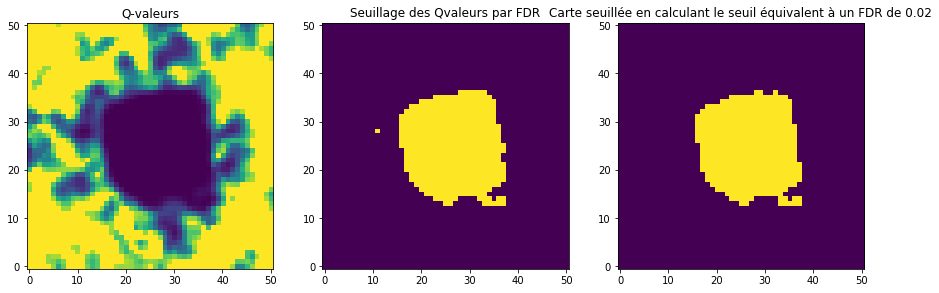

In [24]:
plt.rcParams["figure.figsize"]=(15,15)
plt.subplot(131)
plt.title('Q-valeurs')
plt.imshow(shade1.listResultSources[0].images['DET_QSTAT'].data)
plt.subplot(132)
plt.title(u'Seuillage des Qvaleurs par FDR')
plt.imshow(shade1.listResultSources[0].images['DET_QSTAT'].data<0.02)
plt.subplot(133)
plt.title(u'Carte seuillée en calculant le seuil équivalent à un FDR de 0.02')
seuil=shade1.postprocessing.corrPvalueBH(shade1.listResultSources[0].images['DET_STAT'].data,0.02)
plt.imshow(shade1.listResultSources[0].images['DET_STAT'].data<seuil)